## Data Loader

In [2]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import time
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import pdb
from PIL import Image
from matplotlib import pyplot as plt
import argparse
torch.manual_seed(0)

import torch.nn as nn
import torch.nn.functional as F

print('Using PyTorch version', torch.__version__)


from os.path import isfile
from os import rename
SMOOTH=1
import pdb
from sklearn.metrics import auc, roc_curve
from PIL.ImageFilter import GaussianBlur

# import pdb
from numpy import pi as PI
from numpy import sqrt
from scipy.special import comb
import math

import copy
# tensorflow libraries
# import tensorflow as tf
# from tensorflow import keras
# from keras.preprocessing.image import ImageDataGenerator

Using PyTorch version 1.11.0


In [3]:
# pytorch res, res101..

# Tying papers -> Take inputs from the papers and comparision
# Implementing. LeNet
# EDA. More about Dataset
# Data Augmentation -> Its Benifits
# Can use different dataset on top of this
# Loss plots

In [4]:
# Miscellaneous initialization
torch.manual_seed(1)
start_time = time.time()
parser = argparse.ArgumentParser()

In [5]:
train_dataset_path = ""
test_dataset_path = ""

In [6]:
root_dir = "/Users/harshitb/Desktop/Studies/ECE 228/TB_dataset/TB_Chest_Radiography_Database"
class_names = ['Normal', 'Tuberculosis']
source_dirs = ['Normal', 'Tuberculosis']

In [7]:
parser.add_argument('--num_epochs', type=int, default=5, help='Number of training epochs')
parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
parser.add_argument('--lr', type=float, default=5e-4, help='Learning rate')
parser.add_argument('--l2', type=float, default=0, help='L2 regularisation')
parser.add_argument('--aug', action='store_true', default=False, help='Use data augmentation')
parser.add_argument('--data_path', type=str, default=root_dir,help='Path to data.')
parser.add_argument('--bond_dim', type=int, default=5, help='MPS Bond dimension')
parser.add_argument('--nChannel', type=int, default=1, help='Number of input channels')
parser.add_argument('--dense_net', action='store_true', default=False, help='Using Dense Net model')

args = parser.parse_args([])

In [8]:
batch_size = args.batch_size

# LoTeNet parameters
adaptive_mode = False 
periodic_bc   = False

kernel = 2 # Stride along spatial dimensions
output_dim = 1 # output dimension
 
feature_dim = 2

#logFile = time.strftime("%Y%m%d_%H_%M")+'.txt'
#makeLogFile(logFile)

normTensor = 0.5*torch.ones(args.nChannel)
### Data processing and loading....


In [9]:
### Data processing and loading....
# mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(size=(256,256)),
#                                       transforms.RandomVerticalFlip(),
#                                       transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=normTensor,std=normTensor)])

valid_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(256,256)),
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=normTensor,std=normTensor)
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

In [10]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)}{class_name}')
            return images
        self.images={}
        self.class_names=['Normal', 'Tuberculosis']
        for c in self.class_names:
            self.images[c]=get_images(c)
        self.image_dirs=image_dirs
        self.transform=transform
        
    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    def __getitem__(self, index):
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path =os.path.join(self.image_dirs[class_name], image_name)
        image=Image.open(image_path).convert('L')
        return self.transform(image), self.class_names.index(class_name)

In [11]:
train_dirs = {
    'Normal': root_dir + '/Normal',
    'Tuberculosis': root_dir + '/Tuberculosis'
}
dataset = ChestXRayDataset(train_dirs, train_transform)

Found 3500Normal
Found 700Tuberculosis


In [12]:
f,l = dataset[0]

In [13]:
len(dataset)

4200

In [14]:
trainset, testset, valset = random_split(dataset, [3300, 600, 300])

In [15]:
train_loader =  torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [16]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #         xl = 1
        #         for i in x.shape[1:]: xl *= i
        #         self.fc1 = nn.Linear(13456, 120)
        self.fc1 = nn.Linear(984064, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # -> n, 3, 32, 32
        #         x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        #         x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv1(x))  # -> n, 6, 14, 14
        x = F.relu(self.conv2(x))
        xl = 1
        for i in x.shape[1:]: xl *= i
        x = x.view(-1, xl)            # 
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 2
        return x

In [17]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(59536, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [18]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32768, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 2)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
#         print("HERE ... ", x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [19]:
# Initialising variable that will be used in the experiments in the project

loss_data_of_model_epoch = {}
acc_of_model_epoch = {}
acc_of_model_batch = {}

all_models = {}
all_models['ConvNet'] = ConvNet()
all_models['LeNet5']  = LeNet5()
all_models['VGG16']   = VGG16()

for model_name in all_models.keys():
    loss_data_of_model_epoch[model_name] = {}
    acc_of_model_epoch[model_name] = {}
    acc_of_model_batch[model_name] = {}

In [20]:
def get_acc_from_data(d_loader):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(2)]
        n_class_samples = [0 for i in range(2)]
        for images, labels in d_loader:
            #         print(len(labels))
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        
        all_acc = []
        overall_accuracy = acc
        all_acc.append(overall_accuracy)

        for i in range(2):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {class_names[i]}: {acc} %')
            all_acc.append(acc)
                
    #return all_acc
    return overall_accuracy
    

In [28]:
LeNet5_model_with_epoch = {}

In [29]:

def train_by_model(model, model_name, epo = 3, verbose = True):
    args.num_epochs = epo
    learning_rate = 0.001
    all_loss = []

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    n_total_steps = len(train_loader)
    for epoch in range(args.num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            all_loss.append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if ((i+1) % 10 == 0) and verbose:
                print (f'Epoch [{epoch+1}/{args.num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
        LeNet5_model_with_epoch[epoch+1] = copy.deepcopy(model)
        
    return all_loss

In [30]:
# setting epoch as 3
args.num_epochs = 3

In [31]:
# Checking various architectures above one by one with epoch = 3
# by switching arch in below variable

model_name = "LeNet5"
model = all_models[model_name]

train_by_model(model, model_name)
get_acc_from_data(test_loader)

Epoch [1/3], Step [10/104], Loss: 0.1273
Epoch [1/3], Step [20/104], Loss: 0.2611
Epoch [1/3], Step [30/104], Loss: 0.1776
Epoch [1/3], Step [40/104], Loss: 0.1829
Epoch [1/3], Step [50/104], Loss: 0.2806
Epoch [1/3], Step [60/104], Loss: 0.2890
Epoch [1/3], Step [70/104], Loss: 0.2611
Epoch [1/3], Step [80/104], Loss: 0.1959
Epoch [1/3], Step [90/104], Loss: 0.1702
Epoch [1/3], Step [100/104], Loss: 0.2136
Epoch [2/3], Step [10/104], Loss: 0.2019
Epoch [2/3], Step [20/104], Loss: 0.2601
Epoch [2/3], Step [30/104], Loss: 0.1689
Epoch [2/3], Step [40/104], Loss: 0.2612
Epoch [2/3], Step [50/104], Loss: 0.1429
Epoch [2/3], Step [60/104], Loss: 0.1452
Epoch [2/3], Step [70/104], Loss: 0.0742
Epoch [2/3], Step [80/104], Loss: 0.1289
Epoch [2/3], Step [90/104], Loss: 0.0888
Epoch [2/3], Step [100/104], Loss: 0.1352
Epoch [3/3], Step [10/104], Loss: 0.1016
Epoch [3/3], Step [20/104], Loss: 0.1585
Epoch [3/3], Step [30/104], Loss: 0.1447
Epoch [3/3], Step [40/104], Loss: 0.1810
Epoch [3/3], S

94.5

In [32]:
%%time
# Accuracy for LeNet5 with various epoch

# model_name = 'LeNet5'
# model = LeNet5()
# for i in range(1,16):
#     model = LeNet5()
#     losses = train_by_model(model, model_name, i)
#     loss_data_of_model_epoch[model_name][i] = losses
#     print("Epoch done: ", i, " Calculating accuracy")
#     acc_of_model_epoch[model_name][i] = get_acc_from_data(test_loader)

model = LeNet5()
model_name = "LeNet5"

losses = train_by_model(model, model_name, 15)

Epoch [1/15], Step [10/104], Loss: 0.6840
Epoch [1/15], Step [20/104], Loss: 0.5593
Epoch [1/15], Step [30/104], Loss: 0.5205
Epoch [1/15], Step [40/104], Loss: 0.4747
Epoch [1/15], Step [50/104], Loss: 0.4049
Epoch [1/15], Step [60/104], Loss: 0.3230
Epoch [1/15], Step [70/104], Loss: 0.3216
Epoch [1/15], Step [80/104], Loss: 0.2939
Epoch [1/15], Step [90/104], Loss: 0.2618
Epoch [1/15], Step [100/104], Loss: 0.2193
Epoch [2/15], Step [10/104], Loss: 0.2772
Epoch [2/15], Step [20/104], Loss: 0.3232
Epoch [2/15], Step [30/104], Loss: 0.1954
Epoch [2/15], Step [40/104], Loss: 0.1894
Epoch [2/15], Step [50/104], Loss: 0.2655
Epoch [2/15], Step [60/104], Loss: 0.2520
Epoch [2/15], Step [70/104], Loss: 0.3182
Epoch [2/15], Step [80/104], Loss: 0.2444
Epoch [2/15], Step [90/104], Loss: 0.2091
Epoch [2/15], Step [100/104], Loss: 0.1380
Epoch [3/15], Step [10/104], Loss: 0.1146
Epoch [3/15], Step [20/104], Loss: 0.0950
Epoch [3/15], Step [30/104], Loss: 0.1926
Epoch [3/15], Step [40/104], Los

Maximum accuracy is  99.16666666666667  with epoch as  12


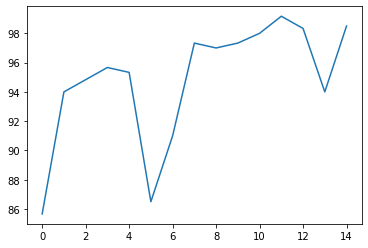

In [36]:
accs = {}
for epo in LeNet5_model_with_epoch:
    print("Calculating accuracy of model with epoch: ", epo)
    model = LeNet5_model_with_epoch[epo]
    acc = get_acc_from_data(test_loader)
    accs[epo] = acc

plt.plot(list(accs.values()))

acc_of_model_epoch[model_name] = accs

model_name = "LeNet5"
max_acc_epo = 1
max_acc = acc_of_model_epoch[model_name][max_acc_epo]
for epo in acc_of_model_epoch[model_name]:
    if max_acc < acc_of_model_epoch[model_name][epo]:
        max_acc = acc_of_model_epoch[model_name][epo]
        max_acc_epo = epo

print("Maximum accuracy is ", max_acc, " with epoch as ", max_acc_epo)

Maximum accuracy is  95.16666666666667  with epoch as  3


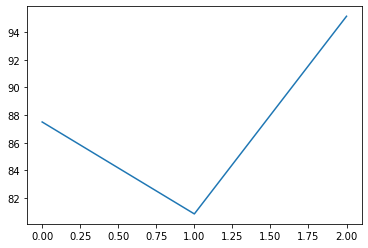

In [24]:
# Getting Epoch that gives highest accuracy

model_name = "LeNet5"
acc_of_model_epoch
max_acc_epo = 1
max_acc = acc_of_model_epoch[model_name][max_acc_epo]
for epo in acc_of_model_epoch[model_name]:
    if max_acc < acc_of_model_epoch[model_name][epo]:
        max_acc = acc_of_model_epoch[model_name][epo]
        max_acc_epo = epo

print("Maximum accuracy is ", max_acc, " with epoch as ", max_acc_epo)

# loss_data_of_model_epoch
# acc_of_model_epoch

import json
with open('loss_data_of_model_epoch_t.json', 'w') as fp:
    json.dump(loss_data_of_model_epoch, fp)
    
with open('acc_of_model_epoch_t.json', 'w') as fp:
    json.dump(acc_of_model_epoch, fp)

all_accuracies = []
for epo in acc_of_model_epoch[model_name]:
    all_accuracies.append(acc_of_model_epoch[model_name][epo])

plt.plot(all_accuracies)

In [ ]:
%%time

# Experiment with various batch sizes for LeNet5 with epoch = 5


for bs in [16, 32, 64]:
    print("Batch Size: ", bs)
    train_loader =  torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
    test_loader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=bs, shuffle=True)
    model = LeNet5()
    train_by_model(model, model_name, 5)
    acc_of_model_batch[model_name][bs] = get_acc_from_data(test_loader)

Batch Size:  16
Epoch [1/5], Step [10/207], Loss: 0.6068
Epoch [1/5], Step [20/207], Loss: 0.5503
Epoch [1/5], Step [30/207], Loss: 0.6159
Epoch [1/5], Step [40/207], Loss: 0.4328
Epoch [1/5], Step [50/207], Loss: 0.3719
Epoch [1/5], Step [60/207], Loss: 0.3254
Epoch [1/5], Step [70/207], Loss: 0.3624
Epoch [1/5], Step [80/207], Loss: 0.4185
Epoch [1/5], Step [90/207], Loss: 0.2952
Epoch [1/5], Step [100/207], Loss: 0.2442
Epoch [1/5], Step [110/207], Loss: 0.2040
Epoch [1/5], Step [120/207], Loss: 0.2007
Epoch [1/5], Step [130/207], Loss: 0.2323
Epoch [1/5], Step [140/207], Loss: 0.3009
Epoch [1/5], Step [150/207], Loss: 0.3715
Epoch [1/5], Step [160/207], Loss: 0.1898
Epoch [1/5], Step [170/207], Loss: 0.2887
Epoch [1/5], Step [180/207], Loss: 0.1570
Epoch [1/5], Step [190/207], Loss: 0.3488
Epoch [1/5], Step [200/207], Loss: 0.2307
Epoch [2/5], Step [10/207], Loss: 0.1339
Epoch [2/5], Step [20/207], Loss: 0.1879
Epoch [2/5], Step [30/207], Loss: 0.1315
Epoch [2/5], Step [40/207], Lo

In [ ]:
# Getting Batch Size that gives highest accuracy

# model_name = "LeNet5"
# max_acc_bat = 16
# max_acc = acc_of_model_batch[model_name][max_acc_epo]
# for bat in acc_of_model_batch[model_name]:
#     if max_acc < acc_of_model_batch[model_name][bat]:
#         max_acc = acc_of_model_batch[model_name][bat]
#         max_acc_bat = bat 

# print("Maximum accuracy is ", max_acc, " with epoch as ", max_acc_epo)

print("Upon analyzing the runtime and accuracy of data we took the following parameters forward")
print("Batch Size: 32")

In [37]:
args.num_epochs = 10
batch_size = 32

train_loader =  torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

model = LeNet5()
model_name = "LeNet5"

losses = train_by_model(model, model_name, args.num_epochs)

Epoch [1/12], Step [10/104], Loss: 0.6247
Epoch [1/12], Step [20/104], Loss: 0.5910
Epoch [1/12], Step [30/104], Loss: 0.5032
Epoch [1/12], Step [40/104], Loss: 0.4859
Epoch [1/12], Step [50/104], Loss: 0.4333
Epoch [1/12], Step [60/104], Loss: 0.3397
Epoch [1/12], Step [70/104], Loss: 0.3642
Epoch [1/12], Step [80/104], Loss: 0.3356
Epoch [1/12], Step [90/104], Loss: 0.3028
Epoch [1/12], Step [100/104], Loss: 0.2621
Epoch [2/12], Step [10/104], Loss: 0.2415
Epoch [2/12], Step [20/104], Loss: 0.3314
Epoch [2/12], Step [30/104], Loss: 0.1760
Epoch [2/12], Step [40/104], Loss: 0.1996
Epoch [2/12], Step [50/104], Loss: 0.3239
Epoch [2/12], Step [60/104], Loss: 0.3211
Epoch [2/12], Step [70/104], Loss: 0.1806
Epoch [2/12], Step [80/104], Loss: 0.1462
Epoch [2/12], Step [90/104], Loss: 0.2373
Epoch [2/12], Step [100/104], Loss: 0.1783
Epoch [3/12], Step [10/104], Loss: 0.2220
Epoch [3/12], Step [20/104], Loss: 0.1395
Epoch [3/12], Step [30/104], Loss: 0.3350
Epoch [3/12], Step [40/104], Los

In [38]:
get_acc_from_data(test_loader)

Accuracy of the network: 97.33333333333333 %
Accuracy of Normal: 96.78571428571429 %
Accuracy of Tuberculosis: 97.8125 %


97.33333333333333

In [41]:
get_acc_from_data(val_loader)

Accuracy of the network: 99.33333333333333 %
